In [18]:
import numpy as np
import struct
from array import array
import os
from os.path  import join
import random as rn
import graphviz
import pydotplus
from IPython.display import Image
from io import StringIO
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import time

In [3]:
"""
Got this code from https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook for 
instructions on how to load data from the MNIST dataset
"""
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
#             img = img.reshape(28, 28)
            images[i][:] = img            
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

In [4]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'data/mnist_datafolder'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [5]:
"""
Setting up seed values for reproducability
"""
seed = 1234
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [6]:
"""
Getting the size values for the training and testing dataset
"""
size_train_samples = np.shape(x_train)[0]
size_test_samples = np.shape(x_test)[0]

In [11]:
"""
This is to split up the data into sets where the size of the training data across iterations
increases by a certain percentage.
This is to prep the data for the Learning Curve Visualization
"""
learning_percentages_train_list = []
learning_percentages_label_list = []
for i in (np.logspace(-1, 1.0, 20, base=10.0) / 10):
    random_indexes = np.random.choice(size_train_samples, int(i * size_train_samples), replace = False)
    learning_percentages_train_list.append(np.take(x_train, random_indexes, axis=0))
    learning_percentages_label_list.append(np.take(y_train, random_indexes))

In [12]:
"""
Actually training the SVC to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.
"""
# Defining hyperparameters here
n_neighbors = 5
weights = 'uniform'
p = 2

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list = []
avg_validation_scores_list = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = KNeighborsClassifier(
    n_neighbors=n_neighbors,
    weights=weights,
    p=p,
)

# Main loop for the training based on different training sample sizes
for i in range(0, len(learning_percentages_train_list)):
    scores = cross_validate(
        clf,
        learning_percentages_train_list[i],
        learning_percentages_label_list[i],
        scoring="accuracy",
        return_train_score=True,
        cv=5,
        n_jobs=10,
    )
    
    avg_train_scores = np.average(scores['train_score'])
    avg_validation_scores = np.average(scores['test_score'])
    
    x_axis_list.append(len(learning_percentages_train_list[i]))
    avg_train_scores_list.append(avg_train_scores)
    avg_validation_scores_list.append(avg_validation_scores)
    
    print("=============================================")
    print("Run for " + str(len(learning_percentages_train_list[i])) + " size")
    print("Average Training Score: " + str(avg_train_scores))
    print("Average Validation Score: " + str(avg_validation_scores))
    print("=============================================")

    

Run for 600 size
Average Training Score: 0.8716666666666667
Average Validation Score: 0.79
Run for 764 size
Average Training Score: 0.9041221398543051
Average Validation Score: 0.8416494668042654
Run for 974 size
Average Training Score: 0.9070840327836477
Average Validation Score: 0.8511075865715041
Run for 1241 size
Average Training Score: 0.9155922099860312
Average Validation Score: 0.8751133566524162
Run for 1581 size
Average Training Score: 0.9353257117126133
Average Validation Score: 0.8975462205007387
Run for 2015 size
Average Training Score: 0.9303970223325061
Average Validation Score: 0.8937965260545905
Run for 2568 size
Average Training Score: 0.9373057851631259
Average Validation Score: 0.9014828467623881
Run for 3273 size
Average Training Score: 0.9442405807475547
Average Validation Score: 0.9126175969372271
Run for 4171 size
Average Training Score: 0.9503117434131809
Average Validation Score: 0.9211229339881388


/Users/brandenkim/miniconda3/envs/ai_env/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Run for 5315 size
Average Training Score: 0.9547036688617123
Average Validation Score: 0.929444967074318


/Users/brandenkim/miniconda3/envs/ai_env/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Run for 6773 size
Average Training Score: 0.955891044396175
Average Validation Score: 0.9316402404792143
Run for 8630 size
Average Training Score: 0.959125144843569
Average Validation Score: 0.9414831981460023
Run for 10997 size
Average Training Score: 0.9649677245619108
Average Validation Score: 0.9485324734383397
Run for 14014 size
Average Training Score: 0.9671043054301091
Average Validation Score: 0.9499070665339445
Run for 17858 size
Average Training Score: 0.9686695036309955
Average Validation Score: 0.9532424316449889
Run for 22756 size
Average Training Score: 0.9723039963751777
Average Validation Score: 0.9582085128550901
Run for 28997 size
Average Training Score: 0.9735748581340932
Average Validation Score: 0.9603063607875317
Run for 36950 size
Average Training Score: 0.9773004059539918
Average Validation Score: 0.9653044654939107
Run for 47085 size
Average Training Score: 0.9787458851014124
Average Validation Score: 0.9679303387490709
Run for 60000 size
Average Training Score

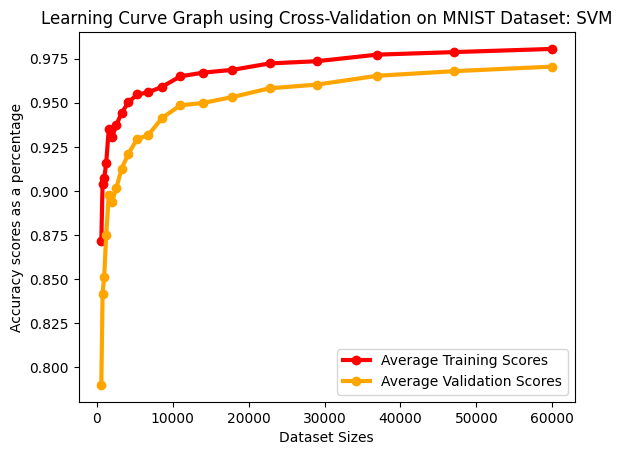

In [13]:
"""
Plotting the results into a learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Learning Curve Graph using Cross-Validation on MNIST Dataset: SVM")

plt.legend()

plt.show()

In [23]:
"""
Actually training the SVC to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.
"""
# Defining hyperparameters here
n_neighbors = 5
weights = 'uniform'
p = 2
k_low = 1
k_high = 15

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list = []
avg_validation_scores_list = []



# Main loop for the training based on different training sample sizes
for i in range(k_low, k_high):
    # First declaring the Decision Tree Classifer from scikit-learn
    clf = KNeighborsClassifier(
        n_neighbors=i,
        weights=weights,
        p=p,
    )
    scores = cross_validate(
        clf,
        x_train[:10000],
        y_train[:10000],
        scoring="accuracy",
        return_train_score=True,
        cv=5,
        n_jobs=10,
    )
    
    avg_train_scores = np.average(scores['train_score'])
    avg_validation_scores = np.average(scores['test_score'])
    
    x_axis_list.append(i)
    avg_train_scores_list.append(avg_train_scores)
    avg_validation_scores_list.append(avg_validation_scores)
    
    print("=============================================")
    print("Run for " + str(i) + " size")
    print("Average Training Score: " + str(avg_train_scores))
    print("Average Validation Score: " + str(avg_validation_scores))
    print("=============================================")

    

Run for 1 size
Average Training Score: 1.0
Average Validation Score: 0.9393
Run for 2 size
Average Training Score: 0.97165
Average Validation Score: 0.9307000000000001
Run for 3 size
Average Training Score: 0.9732750000000001
Average Validation Score: 0.9395000000000001
Run for 4 size
Average Training Score: 0.96685
Average Validation Score: 0.9405000000000001
Run for 5 size
Average Training Score: 0.9640000000000001
Average Validation Score: 0.9377000000000001
Run for 6 size
Average Training Score: 0.959
Average Validation Score: 0.9362999999999999
Run for 7 size
Average Training Score: 0.9567
Average Validation Score: 0.9359999999999999
Run for 8 size
Average Training Score: 0.954025
Average Validation Score: 0.9343999999999999
Run for 9 size
Average Training Score: 0.95235
Average Validation Score: 0.9345000000000001
Run for 10 size
Average Training Score: 0.9510249999999999
Average Validation Score: 0.9341000000000002
Run for 11 size
Average Training Score: 0.94885
Average Validati

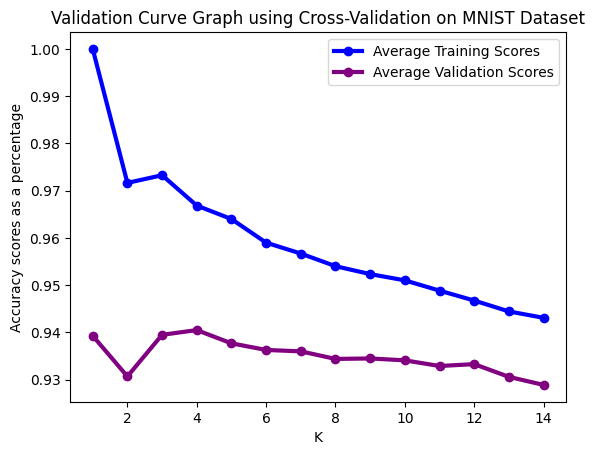

In [24]:
"""
Plotting the results into a validation curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list,
    color="blue",
    linewidth=3,
    marker='o',
    label = "Average Training Scores"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list,
    color="purple",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores"
)

# Naming X-Axis
plt.xlabel('K')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Validation Curve Graph using Cross-Validation on MNIST Dataset")

plt.legend()

plt.show()

In [19]:
"""
Actually training the SVC to generate the graph for the learning graph visualizer.
This should utilize the percentage of samples lists that use randomly selected samples of the
overall training data. This is so that we can test the accuracy (using cross-validation) across different
training data size samples to see at what point the accuracy score stops being affected by the size of the training
samples. This is also to see at what point the data might start getting overfit.
"""
# Defining hyperparameters here
n_neighbors = 5
weights = 'uniform'
p = 2

# lists to hold the results of training / validation scores
x_axis_list = []
avg_train_scores_list = []
avg_validation_scores_list = []
iteration_wall_clock_list = []

# First declaring the Decision Tree Classifer from scikit-learn
clf = KNeighborsClassifier(
    n_neighbors=n_neighbors,
    weights=weights,
    p=p,
)

# Main loop for the training based on different training sample sizes
for i in range(0, len(learning_percentages_train_list)):
    start_time = time.time()
    scores = cross_validate(
        clf,
        learning_percentages_train_list[i],
        learning_percentages_label_list[i],
        scoring="accuracy",
        return_train_score=True,
        cv=5,
        n_jobs=10,
    )
    training_time = time.time() - start_time
    
    avg_train_scores = np.average(scores['train_score'])
    avg_validation_scores = np.average(scores['test_score'])
    
    x_axis_list.append(len(learning_percentages_train_list[i]))
    avg_train_scores_list.append(avg_train_scores)
    avg_validation_scores_list.append(avg_validation_scores)
    iteration_wall_clock_list.append(training_time)
    
    print("=============================================")
    print("Run for " + str(len(learning_percentages_train_list[i])) + " size")
    print("Average Training Score: " + str(avg_train_scores))
    print("Average Validation Score: " + str(avg_validation_scores))
    print("Training Time: " + str(training_time))
    print("=============================================")

    

Run for 600 size
Average Training Score: 0.8716666666666667
Average Validation Score: 0.79
Training Time: 0.799468994140625
Run for 764 size
Average Training Score: 0.9041221398543051
Average Validation Score: 0.8416494668042654
Training Time: 0.3594498634338379
Run for 974 size
Average Training Score: 0.9070840327836477
Average Validation Score: 0.8511075865715041
Training Time: 0.3968040943145752
Run for 1241 size
Average Training Score: 0.9155922099860312
Average Validation Score: 0.8751133566524162
Training Time: 0.4071638584136963
Run for 1581 size
Average Training Score: 0.9353257117126133
Average Validation Score: 0.8975462205007387
Training Time: 0.5846590995788574
Run for 2015 size
Average Training Score: 0.9303970223325061
Average Validation Score: 0.8937965260545905
Training Time: 0.3741481304168701
Run for 2568 size
Average Training Score: 0.9373057851631259
Average Validation Score: 0.9014828467623881
Training Time: 0.5248520374298096
Run for 3273 size
Average Training Sco

/Users/brandenkim/miniconda3/envs/ai_env/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Run for 5315 size
Average Training Score: 0.9547036688617123
Average Validation Score: 0.929444967074318
Training Time: 1.897787094116211
Run for 6773 size
Average Training Score: 0.955891044396175
Average Validation Score: 0.9316402404792143
Training Time: 3.1268999576568604
Run for 8630 size
Average Training Score: 0.959125144843569
Average Validation Score: 0.9414831981460023
Training Time: 4.4522950649261475
Run for 10997 size
Average Training Score: 0.9649677245619108
Average Validation Score: 0.9485324734383397
Training Time: 7.127786874771118
Run for 14014 size
Average Training Score: 0.9671043054301091
Average Validation Score: 0.9499070665339445
Training Time: 11.179399967193604
Run for 17858 size
Average Training Score: 0.9686695036309955
Average Validation Score: 0.9532424316449889
Training Time: 25.746343851089478
Run for 22756 size
Average Training Score: 0.9723039963751777
Average Validation Score: 0.9582085128550901
Training Time: 41.8551983833313


KeyboardInterrupt: 

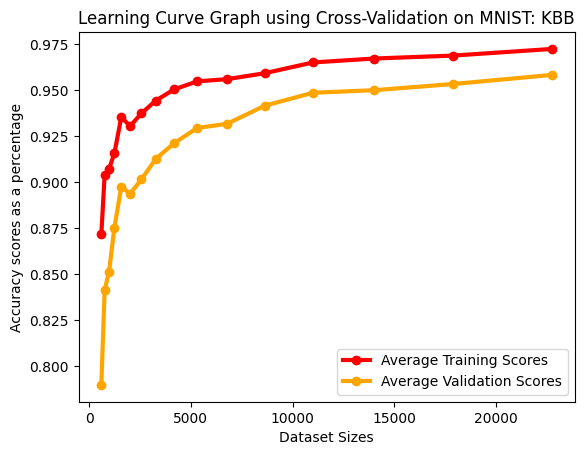

In [20]:
"""
Plotting the results into a learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    avg_train_scores_list,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores"
)

# Plotting the validation scores
plt.plot(
    x_axis_list,
    avg_validation_scores_list,
    color="orange",
    linewidth=3,
    marker='o',
    label = "Average Validation Scores"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Accuracy scores as a percentage')
# Naming Title
plt.title("Learning Curve Graph using Cross-Validation on MNIST: KBB")

plt.legend()

plt.show()

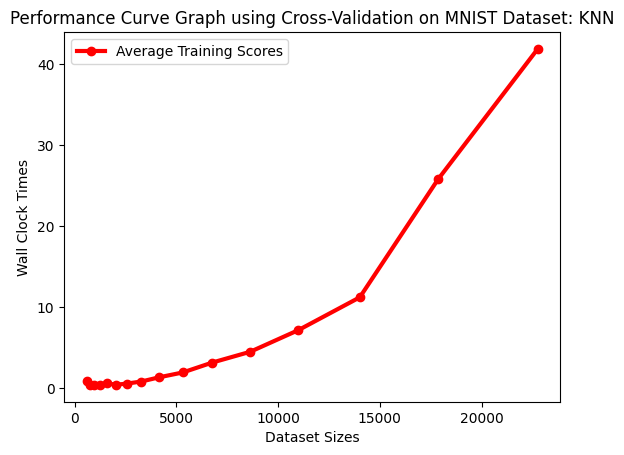

In [21]:
"""
Plotting the results into a learning curve graph
"""

# Plotting the training scores
plt.plot(
    x_axis_list,
    iteration_wall_clock_list,
    color="red",
    linewidth=3,
    marker='o',
    label = "Average Training Scores"
)

# Naming X-Axis
plt.xlabel('Dataset Sizes')
# Naming Y-Axis
plt.ylabel('Wall Clock Times')
# Naming Title
plt.title("Performance Curve Graph using Cross-Validation on MNIST Dataset: KNN")

plt.legend()

plt.show()

In [22]:
clf.fit(x_train[:10000], y_train[:10000])
start_time = time.time()
score = clf.score(x_test, y_test)
training_time = time.time() - start_time
print(score)
print(training_time)

0.9442
2.78912091255188
